# Decision Tree Classifier 

## Load in libraries

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedFormatter, FixedLocator

## Load data

In [48]:
clean_data = np.loadtxt('data/wifi_db/clean_dataset.txt')
noisy_data = np.loadtxt('data/wifi_db/noisy_dataset.txt')

## Create structure to store decision tree nodes

In [49]:
class Node:
    def __init__(self, feature, split, left, right, leaf, users, depth):
        self.feature = feature
        self.split = split
        self.left = left
        self.right = right
        self.leaf = leaf
        self.users = users
        self.depth = depth

    def eval(self, data):
        if self.leaf:
            return self.feature
        if data[self.feature] < self.split:
            return self.left.eval(data)
        else:
            return self.right.eval(data)


## Decision tree creating algorithm


In [50]:
def decisionTreeLearning(data, depth):
    if len(np.unique(data[:, -1])) == 1: #  If all values in last column are the same, return lead
        return Node(np.unique(data[:, -1])[0], 0, None, None, True, len(data), depth), depth
    else:
        feature, split = findSplit(data) #  Find the feature and the value to split upon that gains the most information
        node = Node(feature, split, None, None, False, 0, depth)
        l_branch, l_depth = decisionTreeLearning(data[data[:, feature] < split], depth + 1)
        r_branch, r_depth = decisionTreeLearning(data[data[:, feature] > split], depth + 1)
        node.left = l_branch
        node.right = r_branch
        return node, max(l_depth, r_depth)

## Split algorithm

In [51]:
def findSplit(data): 
    y = data[:, -1]
    H = entropy(y)
    IG = 0
    feature = 0
    split = 0
    rows, cols = data.shape
    for col in range(cols - 1):
        sorted_indices = np.argsort(data[:, col])
        sorted_by_col = data[sorted_indices]
        for row in range(rows - 1):
            if sorted_by_col[row, col] == sorted_by_col[row + 1, col]:
                continue
            pot_split = (sorted_by_col[row, col] + sorted_by_col[row + 1, col])/2
            
            left = sorted_by_col[:row + 1 , -1]
            right = sorted_by_col[row + 1:, -1]

            h_left = entropy(left) if len(left) > 0 else 0
            h_right = entropy(right) if len(right) > 0 else 0
            
            rem = (len(left) / len(y)) * h_left + (len(right) / len(y)) * h_right
            gain  = H - rem
            if gain > IG:
                feature = col
                split = pot_split
                IG = gain
            else:
                continue
 
    return feature, split

## Entropy Calculation

In [52]:
def entropy(labels):
    _, counts = np.unique(labels, return_counts=True)
    probabilites = counts/counts.sum()
    H = - np.sum(probabilites * np.log2(probabilites))
    return H

## Tree Visualisation

In [53]:
def plotTree(node, xcoord=0, ycoord=0, layer=1, width=5.0, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=(30, 30))
    
    if node.leaf:
        ax.text(xcoord, ycoord, f'Room: {node.feature}', bbox = dict(facecolor='green'))
    else:
        ax.text(xcoord, ycoord, f'Feature {node.feature}\nSplit: {node.split}', bbox = dict(facecolor='lightblue'))
        
        left_xcoord = xcoord - 0.5*width
        right_xcoord = xcoord + 0.5*width
        next_ycoord = ycoord - 1 / layer  
        
        if node.left:
            plotTree(node.left, left_xcoord, next_ycoord, layer + 1, width / 2, ax)
            ax.plot([xcoord, left_xcoord], [ycoord, next_ycoord], color='black', label='less')
            ax.annotate('Less', xy=((xcoord + left_xcoord) / 2, (ycoord + next_ycoord) / 2))
        
        if node.right:
            plotTree(node.right, right_xcoord, next_ycoord, layer + 1, width / 2, ax)
            ax.plot([xcoord, right_xcoord], [ycoord, next_ycoord], color='black', label='more')
            ax.annotate('More', xy=((xcoord + right_xcoord) / 2, (ycoord + next_ycoord) / 2))

## Evaluation

Function to simply return accuracy of tree

In [55]:
def evaluate(test_db, trained_tree):
    num_correct = 0
    for data in test_db:
        sample = data[:7]
        prediction = trained_tree.eval(sample)
        if prediction == data[-1]:
            num_correct += 1
    return num_correct/len(test_db)

## Confusion Matrix

In [56]:
def createConfusionMatrix(test_db, trained_tree):
    confusion_matrix = np.zeros((len(np.unique(test_db[:, -1])), len(np.unique(test_db[:, -1]))))
    for data in test_db:
        sample = data[:-1]
        prediction = trained_tree.eval(sample)
        confusion_matrix[int(prediction) - 1, int(data[-1]) - 1] += 1
    return confusion_matrix  # Predictions are along the rows, test values along columns

In [106]:
def visualiseConfusionMatrix(mat, title=""):
    fig, ax = plt.subplots()
    ax.matshow(mat)
    for (i, j), z in np.ndenumerate(mat):
        ax.text(j, i, '{:0.0f}'.format(z), ha='center', va='center')
    ax.xaxis.set_major_locator(FixedLocator([0, 1, 2, 3]))
    ax.xaxis.set_major_formatter(FixedFormatter([f"True Room {x}"  for x in [1, 2, 3, 4]]))

    ax.yaxis.set_major_locator(FixedLocator([0, 1, 2, 3]))
    ax.yaxis.set_major_formatter(FixedFormatter([f"Predicted Room {x}"  for x in [1, 2, 3, 4]]))

    ax.set_title(title)


## Accuracy calculation

In [58]:
def accuracy(confusion_matrix):
    return np.trace(confusion_matrix)/np.sum(confusion_matrix)

## Recall calculation

In [59]:
def recall(confusion_matrix, label):
    tp = confusion_matrix[label, label]
    fn = np.sum(confusion_matrix[:, label]) - tp
    recall = tp/(tp + fn)
    return recall

In [60]:
def recallPerRoom(confusion_matrix):
    recalls = {}
    for i in range(len(confusion_matrix)):
        recalls[f"Room {i + 1}"] = float(recall(confusion_matrix, i))
    return recalls
    

## Precision calculation

In [61]:
def precision(confusion_matrix, label):
    tp = confusion_matrix[label, label]
    fp = np.sum(confusion_matrix[label, :,]) - tp
    precision = tp/(tp + fp)
    return precision

In [62]:
def precisionPerRoom(confusion_matrix):
    precisions = {}
    for i in range(len(confusion_matrix)):
        precisions[f"Room {i + 1}"] = float(recall(confusion_matrix, i))
    return precisions

## F1 measures

In [63]:
def f1Measures(precision, recall):
    f1Scores = {}
    for i in range(len(precision)):
        f1Scores[f"Room {i + 1}"] = float(2*(precision[f"Room {i + 1}"]*recall[f"Room {i + 1}"] / (precision[f"Room {i + 1}"] + recall[f"Room {i + 1}"])))
    return f1Scores

## K Fold Cross Validation

In [64]:
def cross_validation(data, k):
    shuffled_data = np.copy(data)
    np.random.shuffle(shuffled_data)
    cmatrix = np.zeros((4, 4))
    total_depth = 0
    fold_size = len(data) // k
    for i in range(k):
        test = shuffled_data[fold_size*i:fold_size*(i + 1)]
        train = np.vstack((shuffled_data[:fold_size*i], shuffled_data[fold_size*(i+1):]))
        tree, depth = decisionTreeLearning(train, 0)
        cmatrix += createConfusionMatrix(test, tree)
        total_depth += depth
    return cmatrix, total_depth/10


In [107]:
clean_data_confusion_matrix, clean_depth = cross_validation(clean_data, 10)
noisy_data_confusion_matrix, noisy_depth = cross_validation(noisy_data, 10)

## Clean data metrics

avg depth of clean data cross validation is 12.0
accuracy of clean data cross validation is 0.971
recall per room is {'Room 1': 0.982, 'Room 2': 0.958, 'Room 3': 0.96, 'Room 4': 0.984}
precision per room is {'Room 1': 0.982, 'Room 2': 0.958, 'Room 3': 0.96, 'Room 4': 0.984}
f1 score per room is {'Room 1': 0.982, 'Room 2': 0.958, 'Room 3': 0.96, 'Room 4': 0.984}


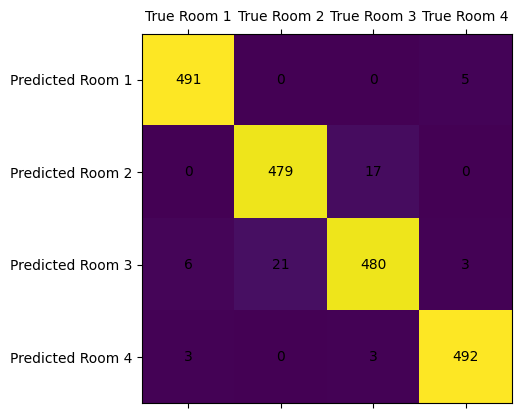

In [108]:
visualiseConfusionMatrix(clean_data_confusion_matrix)
print(f"avg depth of clean data cross validation is {clean_depth}")
print(f"accuracy of clean data cross validation is {accuracy(clean_data_confusion_matrix)}")
print(f"recall per room is {recallPerRoom(clean_data_confusion_matrix)}")
print(f"precision per room is {precisionPerRoom(clean_data_confusion_matrix)}")
print(f"f1 score per room is {f1Measures(precisionPerRoom(clean_data_confusion_matrix), recallPerRoom(clean_data_confusion_matrix))}")

## Noisy Data Metrics

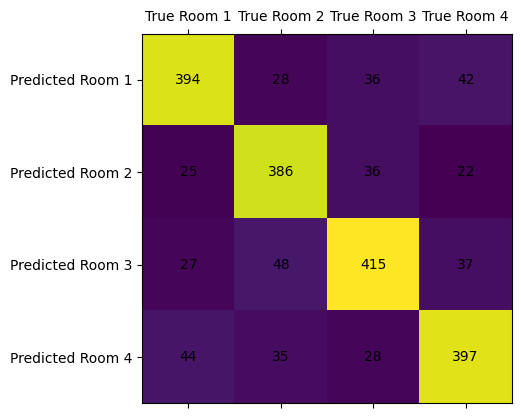

avg depth of clean data cross validation is 19.3
accuracy of noisy data cross validation is 0.796
recall per room is {'Room 1': 0.8040816326530612, 'Room 2': 0.7766599597585513, 'Room 3': 0.8058252427184466, 'Room 4': 0.7971887550200804}
precision per room is {'Room 1': 0.8040816326530612, 'Room 2': 0.7766599597585513, 'Room 3': 0.8058252427184466, 'Room 4': 0.7971887550200804}
f1 score per room is {'Room 1': 0.8040816326530612, 'Room 2': 0.7766599597585513, 'Room 3': 0.8058252427184465, 'Room 4': 0.7971887550200804}


In [67]:
visualiseConfusionMatrix(noisy_data_confusion_matrix)
print(f"avg depth of clean data cross validation is {noisy_depth}")
print(f"accuracy of noisy data cross validation is {accuracy(noisy_data_confusion_matrix)}")
print(f"recall per room is {recallPerRoom(noisy_data_confusion_matrix)}")
print(f"precision per room is {precisionPerRoom(noisy_data_confusion_matrix)}")
print(f"f1 score per room is {f1Measures(precisionPerRoom(noisy_data_confusion_matrix), recallPerRoom(noisy_data_confusion_matrix))}")

## Pruning

In [68]:
def prune_tree(tree, validation, node):
    if node.leaf:
        return node 

    node.left = prune_tree(tree, validation, node.left)
    node.right = prune_tree(tree, validation, node.right)

    if not (node.left.leaf and node.right.leaf):
        return node

    current_accuracy = evaluate(validation, tree)

    feature_backup = node.feature
    split_backup = node.split
    left_backup = node.left
    right_backup = node.right
    users_backup = node.users
    depth_backup = node.depth

    if node.left.users < node.right.users:
        node.feature = node.right.feature
    else:
        node.feature = node.left.feature
    node.users = node.left.users + node.right.users
    node.leaf = True
    node.left = None
    node.right = None
    node.split = None

    pruned_accuracy = evaluate(validation, tree)

    if pruned_accuracy < current_accuracy:
        node.feature = feature_backup
        node.split = split_backup
        node.left = left_backup
        node.right = right_backup
        node.leaf = False
        node.users = users_backup
        node.depth = depth_backup

    return node


## Nested validation

In [98]:
def nested_cross_validation(data, k):
    shuffled_data = np.copy(data)
    np.random.shuffle(shuffled_data)
    outer_folds = np.array_split(shuffled_data, k)

    overall = np.zeros((4, 4))
    total_depth = 0

    for i in range(k):
        test_data = outer_folds[i]
        inner_folds = outer_folds[:i] + outer_folds[i+1:]
        best_inner_accuracy = -1
        best_tree = None
        best_depth = -1
        for j in range(k - 1):
            validation_data_inner = inner_folds[j]
            training_folds_inner = inner_folds[:j] + inner_folds[j+1:]
            training_data_inner = np.concatenate(training_folds_inner, axis=0)
            tree, depth = decisionTreeLearning(training_data_inner, 0)
            pruned_tree = prune_tree(tree, validation_data_inner, tree)
            accuracy = evaluate(validation_data_inner, pruned_tree)
            if accuracy > best_inner_accuracy:
                best_inner_accuracy = accuracy
                best_tree = pruned_tree
                best_depth = calc_depth(pruned_tree)
        total_depth += best_depth
        overall += createConfusionMatrix(test_data, best_tree)

    return overall, total_depth/10


In [99]:
def calc_depth(node):
    if node.leaf:
        return node.depth
    else:
        return max(calc_depth(node.left), calc_depth(node.right))

In [100]:
prune_clean_confusion, prune_clean_depth = nested_cross_validation(clean_data, 10)

In [89]:
prune_noisy_confusion, prune_noisy_depth = nested_cross_validation(noisy_data, 10)

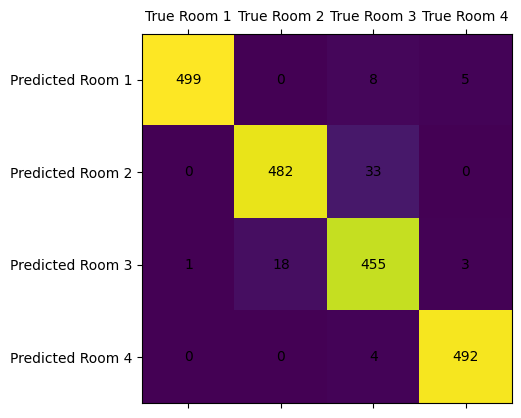

accuracy of prune clean data cross validation is 0.964
avg depth of prune clean data cross validation is 8.9
recall per room is {'Room 1': 0.998, 'Room 2': 0.964, 'Room 3': 0.91, 'Room 4': 0.984}
precision per room is {'Room 1': 0.998, 'Room 2': 0.964, 'Room 3': 0.91, 'Room 4': 0.984}
f1 score per room is {'Room 1': 0.998, 'Room 2': 0.964, 'Room 3': 0.91, 'Room 4': 0.984}


In [101]:
visualiseConfusionMatrix(prune_clean_confusion)
print(f"accuracy of prune clean data cross validation is {accuracy(prune_clean_confusion)}")
print(f"avg depth of prune clean data cross validation is {prune_clean_depth}")
print(f"recall per room is {recallPerRoom(prune_clean_confusion)}")
print(f"precision per room is {precisionPerRoom(prune_clean_confusion)}")
print(f"f1 score per room is {f1Measures(precisionPerRoom(prune_clean_confusion), recallPerRoom(prune_clean_confusion))}")

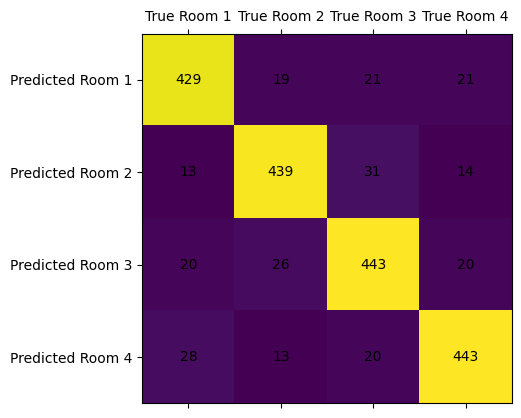

accuracy of prune noisy data cross validation is 0.877
avg depth of prune noisy data cross validation is 14.0
recall per room is {'Room 1': 0.8755102040816326, 'Room 2': 0.8832997987927566, 'Room 3': 0.8601941747572815, 'Room 4': 0.8895582329317269}
precision per room is {'Room 1': 0.8755102040816326, 'Room 2': 0.8832997987927566, 'Room 3': 0.8601941747572815, 'Room 4': 0.8895582329317269}
f1 score per room is {'Room 1': 0.8755102040816327, 'Room 2': 0.8832997987927567, 'Room 3': 0.8601941747572815, 'Room 4': 0.8895582329317269}


In [81]:
visualiseConfusionMatrix(prune_noisy_confusion)
print(f"accuracy of prune noisy data cross validation is {accuracy(prune_noisy_confusion)}")
print(f"avg depth of prune noisy data cross validation is {prune_noisy_depth}")
print(f"recall per room is {recallPerRoom(prune_noisy_confusion)}")
print(f"precision per room is {precisionPerRoom(prune_noisy_confusion)}")
print(f"f1 score per room is {f1Measures(precisionPerRoom(prune_noisy_confusion), recallPerRoom(prune_noisy_confusion))}")

## Script

In [112]:
def main():
    clean_data = np.loadtxt('data/wifi_db/clean_dataset.txt')
    noisy_data = np.loadtxt('data/wifi_db/noisy_dataset.txt')

    clean_tree, _ = decisionTreeLearning(clean_data, 0)
    plotTree(clean_tree)
    print("saving clean tree")
    plt.savefig("clean_tree.png")

    noisy_tree, _ = decisionTreeLearning(noisy_data, 0)
    plotTree(noisy_tree)
    print("saving noisy tree")
    plt.savefig("noisy_tree.png")

    clean_data_confusion_matrix, clean_depth = cross_validation(clean_data, 10)
    noisy_data_confusion_matrix, noisy_depth = cross_validation(noisy_data, 10)

    visualiseConfusionMatrix(clean_data_confusion_matrix)
    print(f"avg depth of clean data cross validation is {clean_depth}")
    print(f"accuracy of clean data cross validation is {accuracy(clean_data_confusion_matrix)}")
    print(f"recall per room is {recallPerRoom(clean_data_confusion_matrix)}")
    print(f"precision per room is {precisionPerRoom(clean_data_confusion_matrix)}")
    print(f"f1 score per room is {f1Measures(precisionPerRoom(clean_data_confusion_matrix), recallPerRoom(clean_data_confusion_matrix))}")

    print("saving clean data confusion matrix")
    plt.savefig("clean_data_cm.png")

    visualiseConfusionMatrix(noisy_data_confusion_matrix)
    print(f"avg depth of clean data cross validation is {noisy_depth}")
    print(f"accuracy of noisy data cross validation is {accuracy(noisy_data_confusion_matrix)}")
    print(f"recall per room is {recallPerRoom(noisy_data_confusion_matrix)}")
    print(f"precision per room is {precisionPerRoom(noisy_data_confusion_matrix)}")
    print(f"f1 score per room is {f1Measures(precisionPerRoom(noisy_data_confusion_matrix), recallPerRoom(noisy_data_confusion_matrix))}")

    print("saving noisy data confusion matrix")
    plt.savefig("noisy_data_cm.png")

    prune_clean_confusion, prune_clean_depth = nested_cross_validation(clean_data, 10)

    visualiseConfusionMatrix(prune_clean_confusion)
    print(f"accuracy of prune clean data cross validation is {accuracy(prune_clean_confusion)}")
    print(f"avg depth of prune clean data cross validation is {prune_clean_depth}")
    print(f"recall per room is {recallPerRoom(prune_clean_confusion)}")
    print(f"precision per room is {precisionPerRoom(prune_clean_confusion)}")
    print(f"f1 score per room is {f1Measures(precisionPerRoom(prune_clean_confusion), recallPerRoom(prune_clean_confusion))}")

    print("saving pruned clean data confusion matrix")
    plt.savefig("prune_clean__data_cm.png")

    prune_noisy_confusion, prune_noisy_depth = nested_cross_validation(noisy_data, 10)

    visualiseConfusionMatrix(prune_noisy_confusion)
    print(f"accuracy of prune noisy data cross validation is {accuracy(prune_noisy_confusion)}")
    print(f"avg depth of prune noisy data cross validation is {prune_noisy_depth}")
    print(f"recall per room is {recallPerRoom(prune_noisy_confusion)}")
    print(f"precision per room is {precisionPerRoom(prune_noisy_confusion)}")
    print(f"f1 score per room is {f1Measures(precisionPerRoom(prune_noisy_confusion), recallPerRoom(prune_noisy_confusion))}")

    print("saving pruned noisy data confusion matrix")
    plt.savefig("prune_noisy__data_cm.png")

saving clean tree
saving noisy tree
avg depth of clean data cross validation is 12.2
accuracy of clean data cross validation is 0.9715
recall per room is {'Room 1': 0.984, 'Room 2': 0.958, 'Room 3': 0.958, 'Room 4': 0.986}
precision per room is {'Room 1': 0.984, 'Room 2': 0.958, 'Room 3': 0.958, 'Room 4': 0.986}
f1 score per room is {'Room 1': 0.984, 'Room 2': 0.958, 'Room 3': 0.958, 'Room 4': 0.986}
saving clean data confusion matrix
avg depth of clean data cross validation is 18.2
accuracy of noisy data cross validation is 0.8025
recall per room is {'Room 1': 0.789795918367347, 'Room 2': 0.8209255533199196, 'Room 3': 0.8058252427184466, 'Room 4': 0.7931726907630522}
precision per room is {'Room 1': 0.789795918367347, 'Room 2': 0.8209255533199196, 'Room 3': 0.8058252427184466, 'Room 4': 0.7931726907630522}
f1 score per room is {'Room 1': 0.789795918367347, 'Room 2': 0.8209255533199196, 'Room 3': 0.8058252427184465, 'Room 4': 0.7931726907630522}
saving noisy data confusion matrix
accur

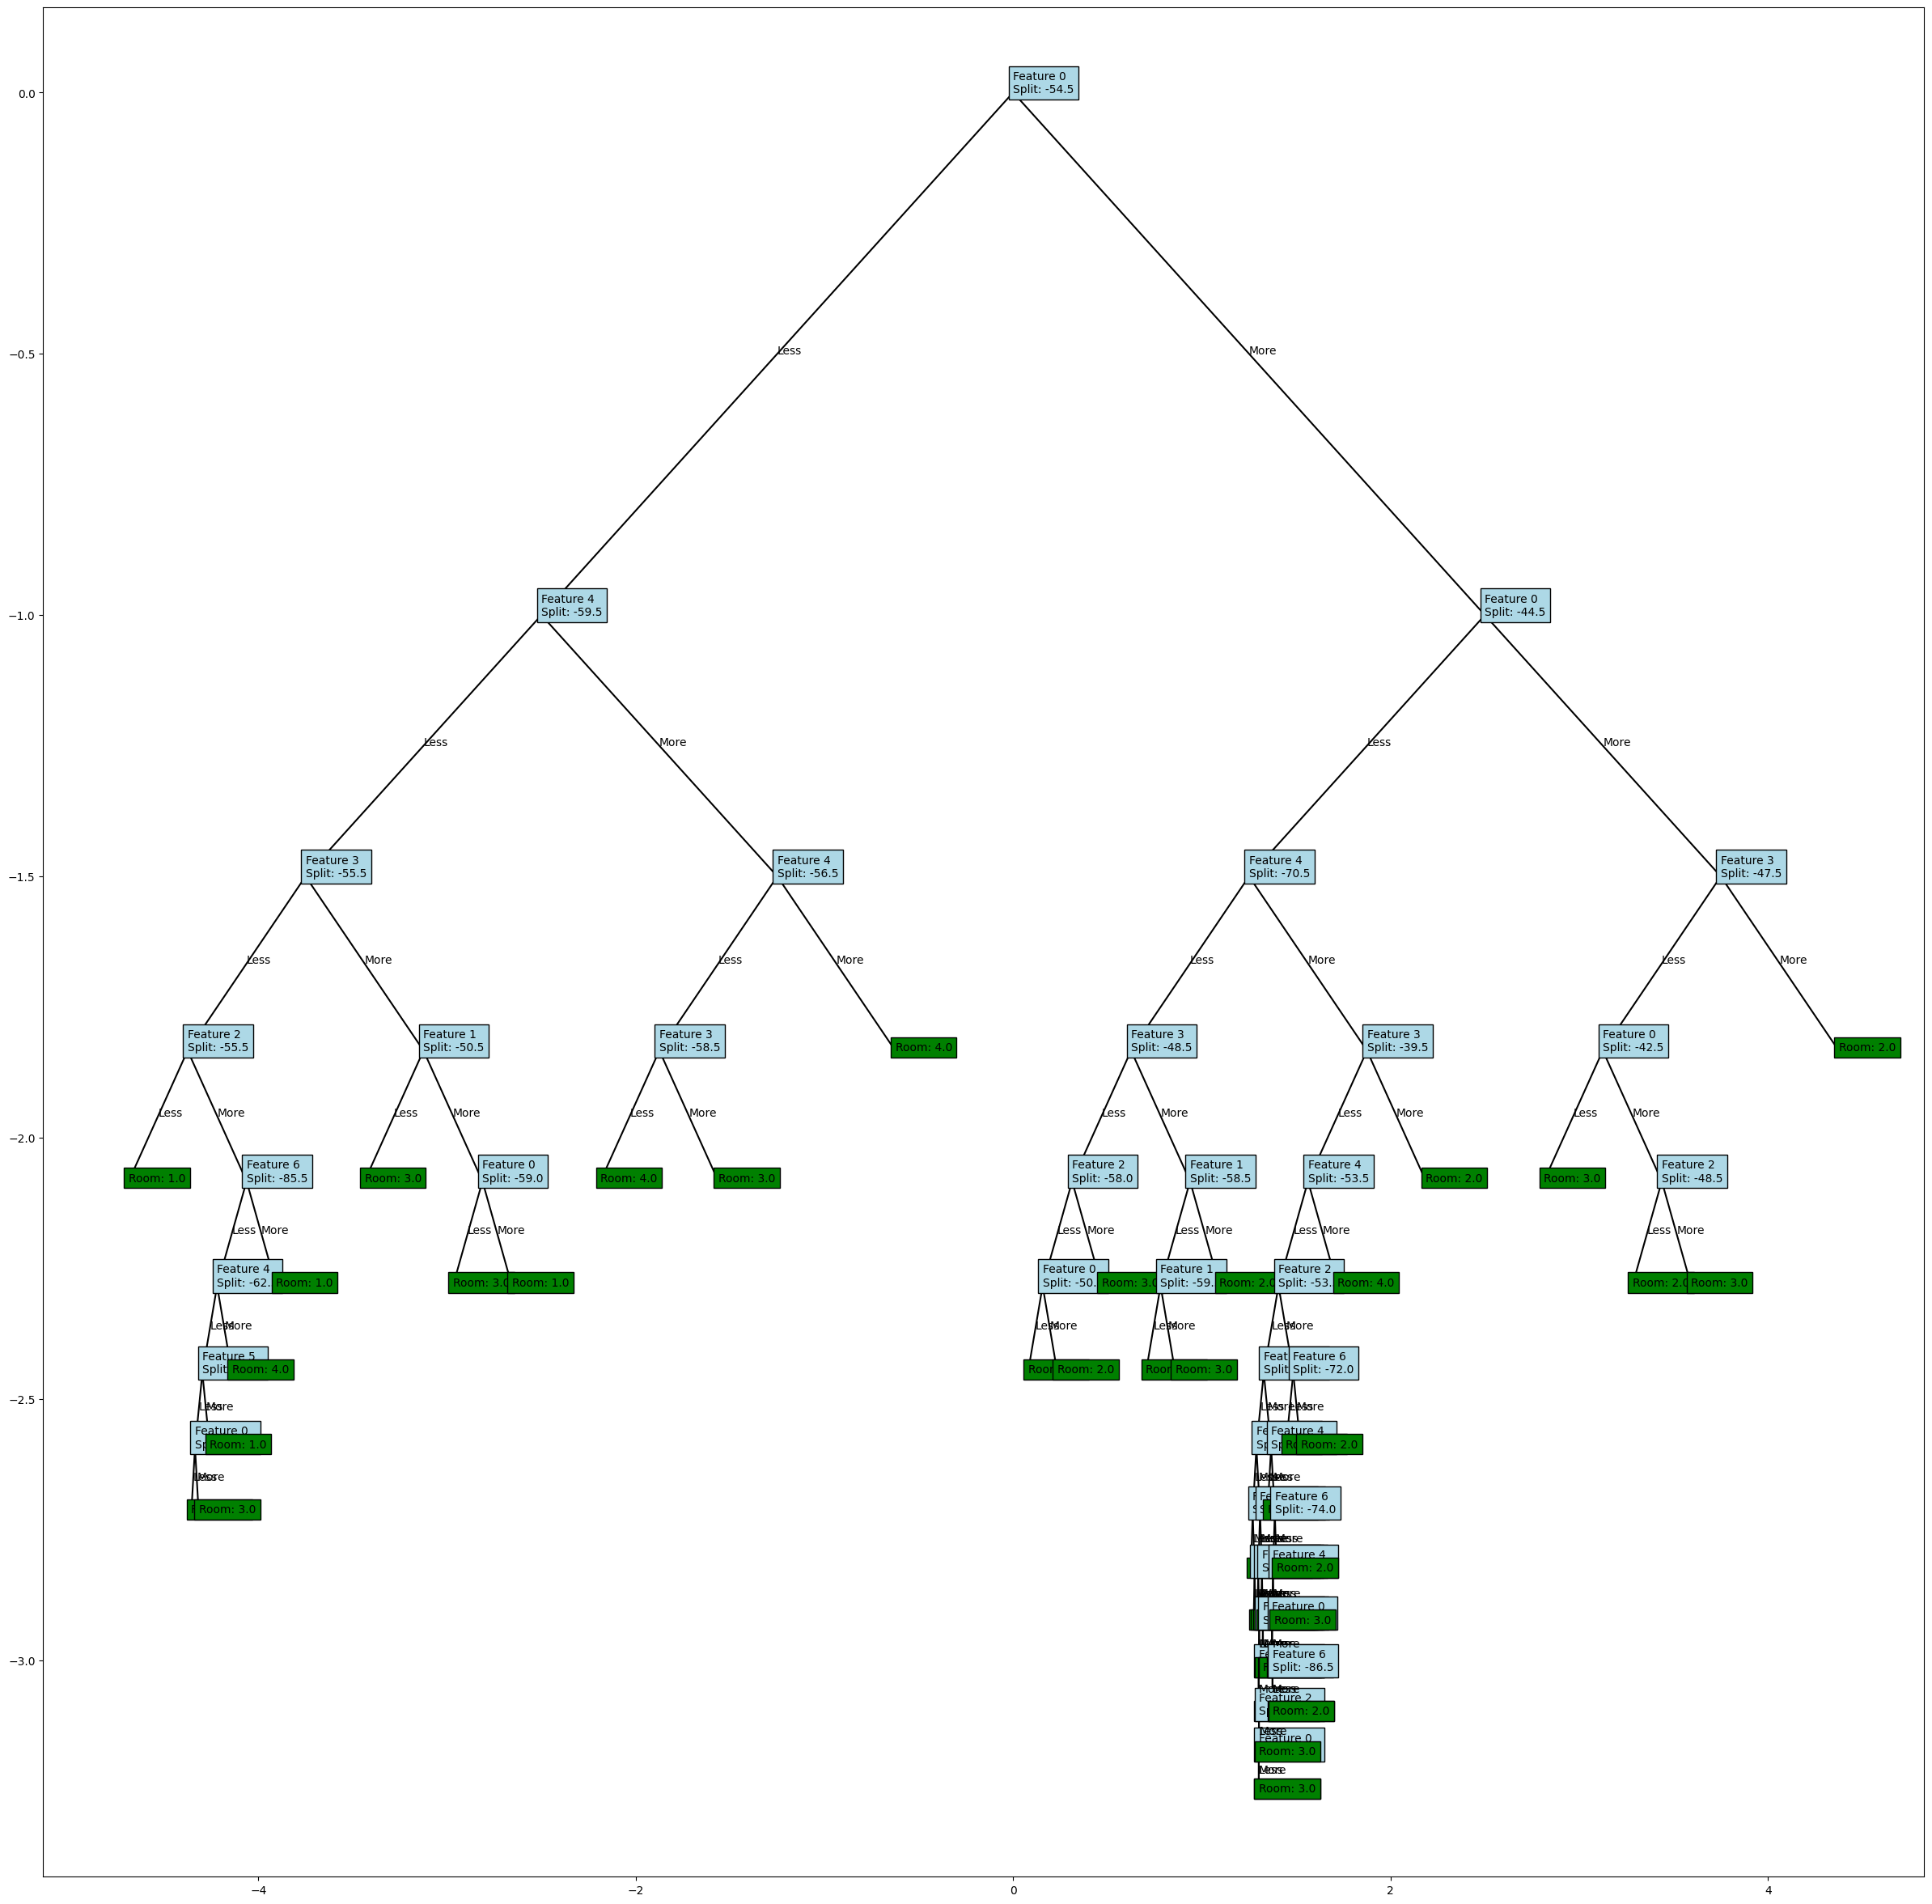

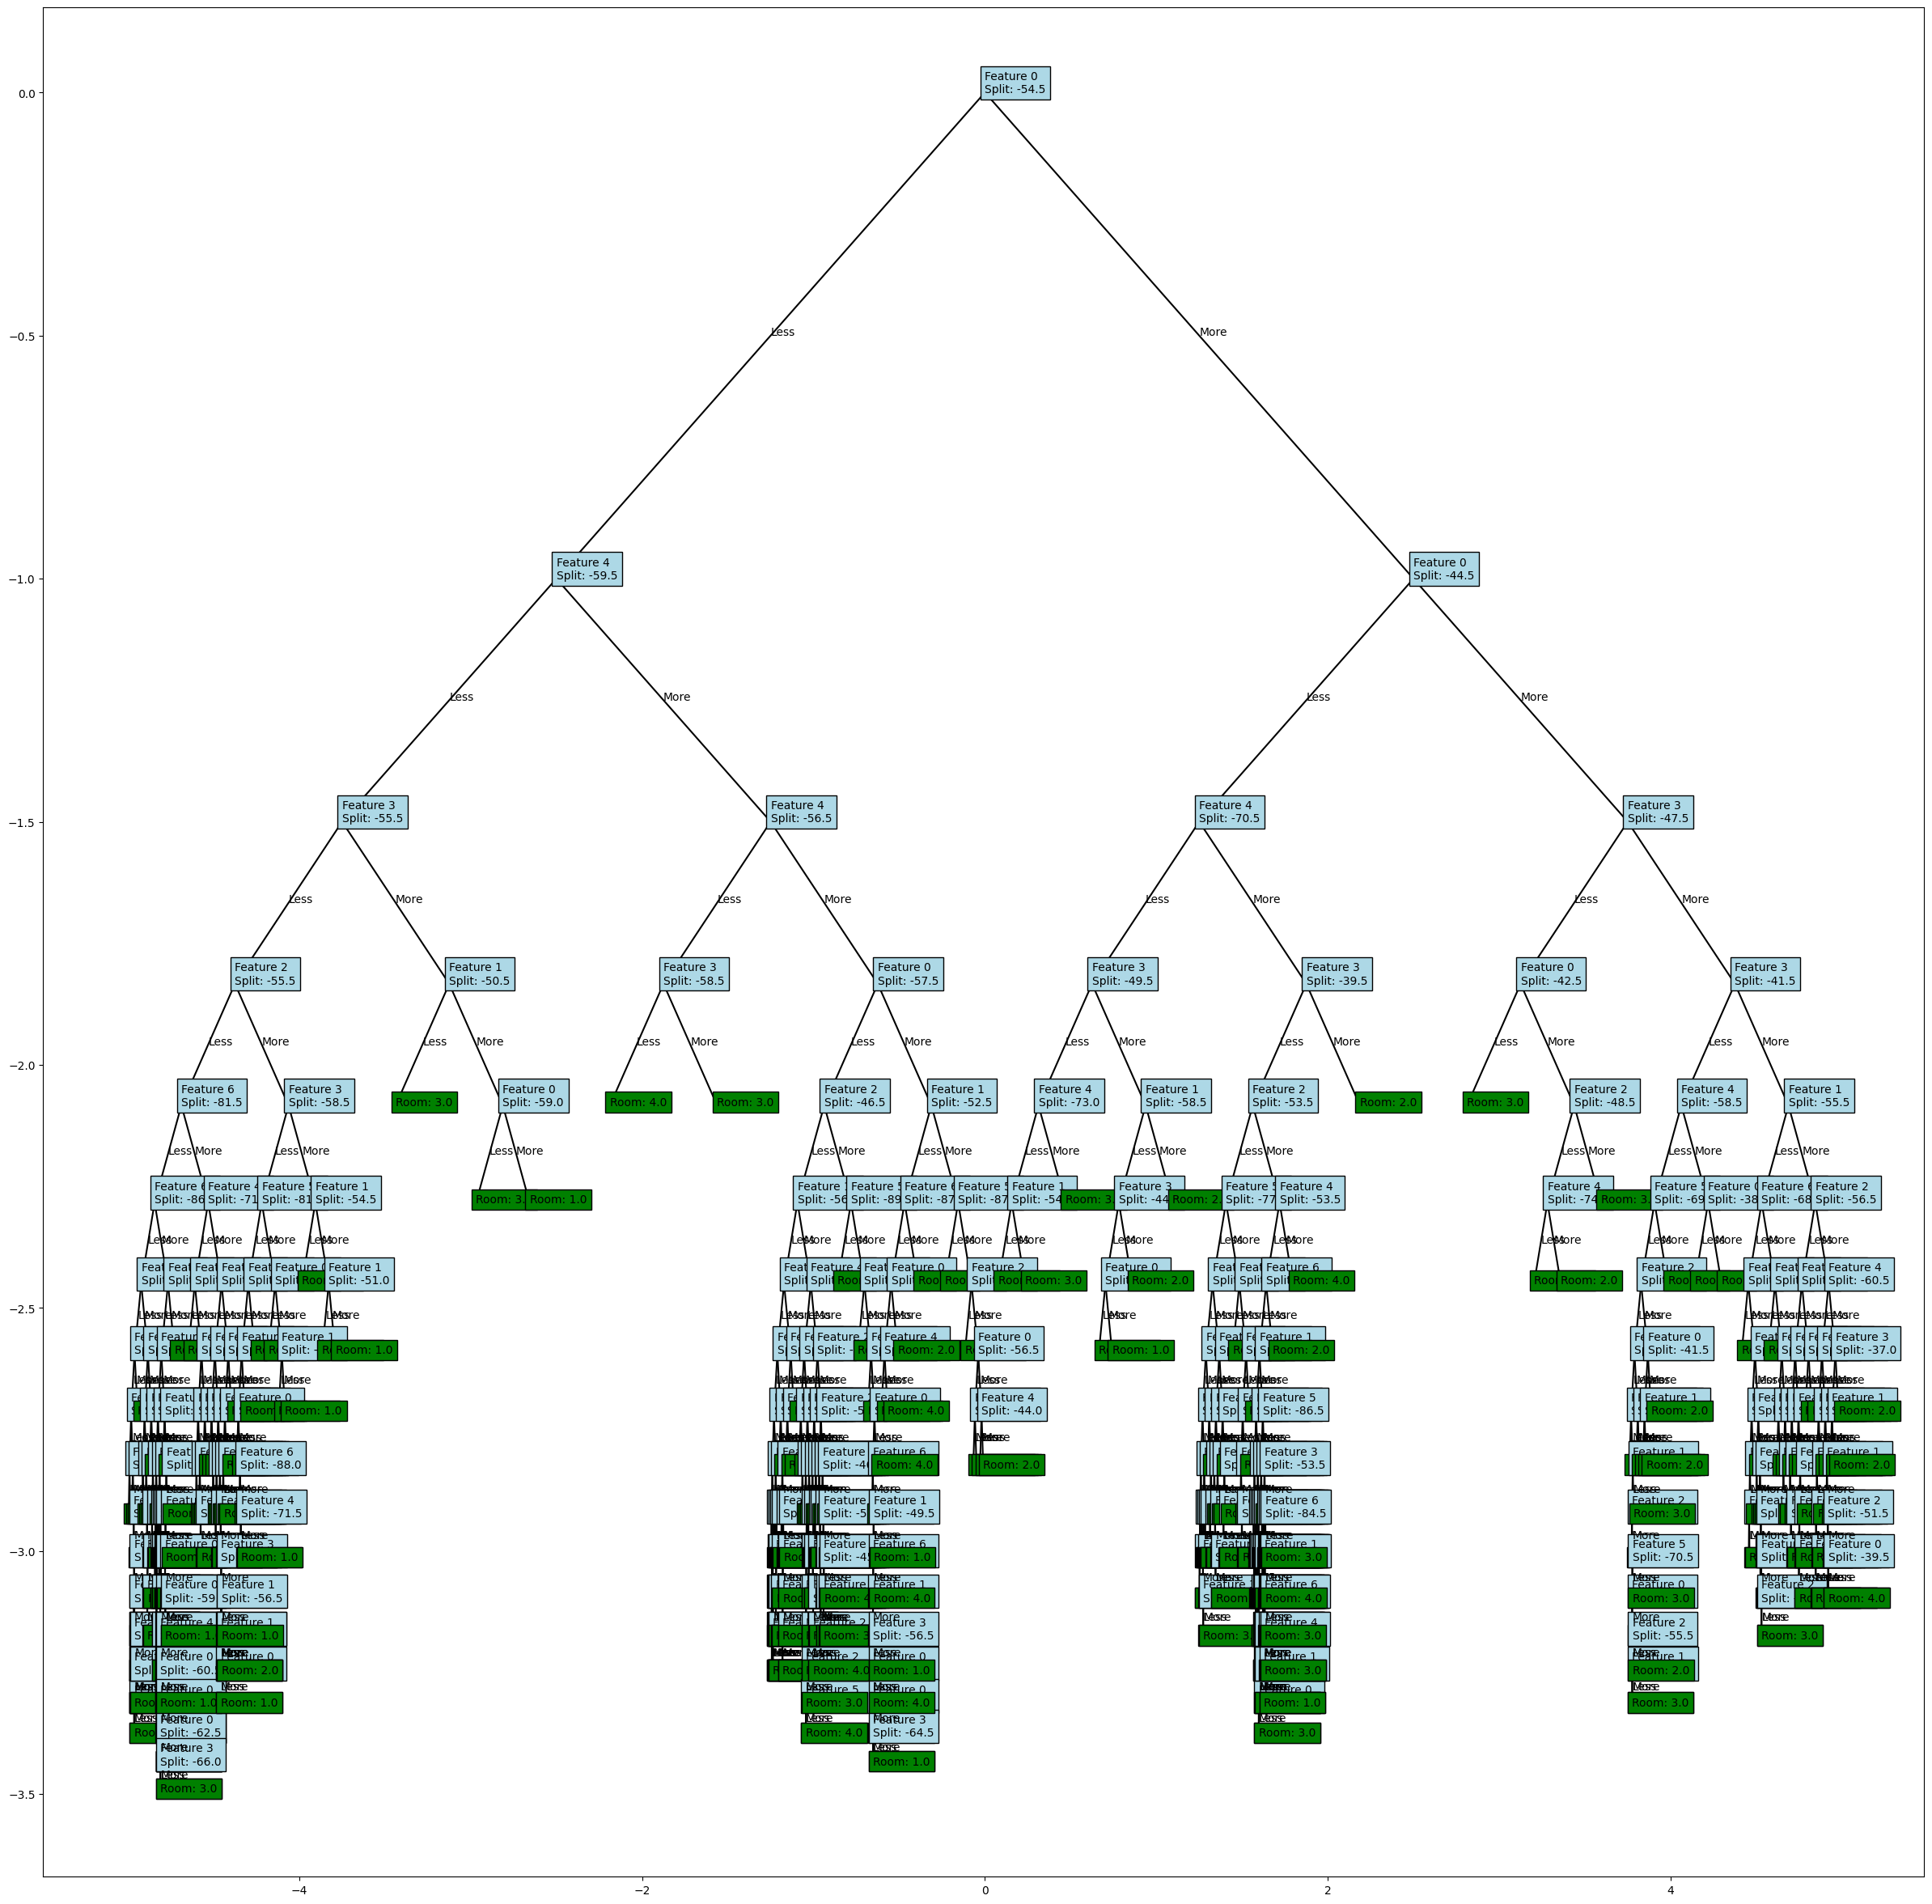

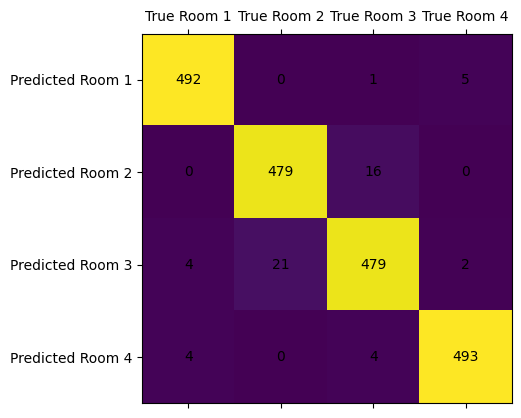

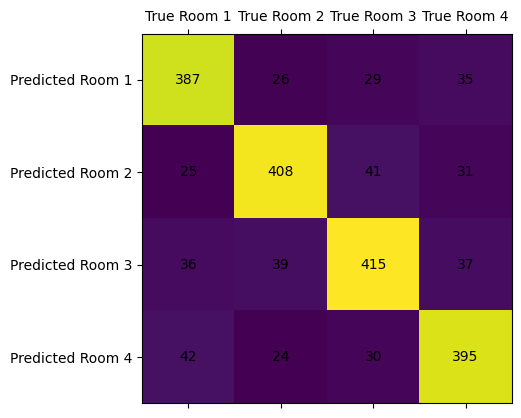

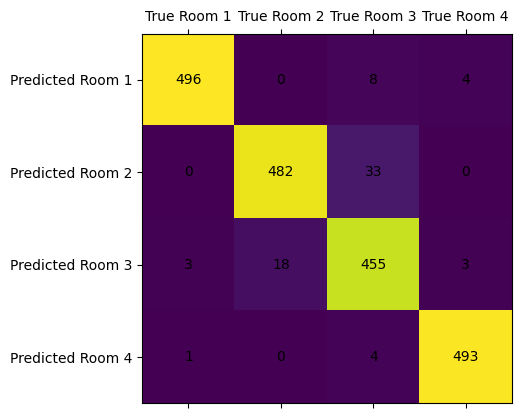

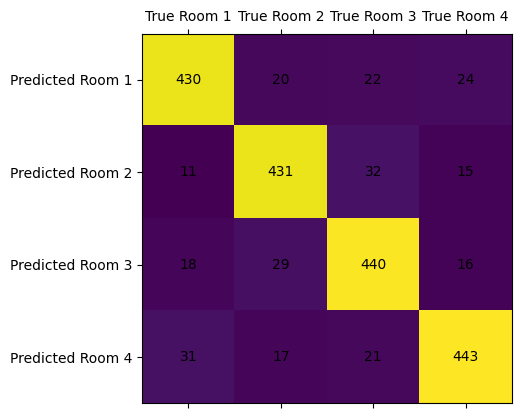

In [113]:
if __name__ == "__main__":
    main()